# _Importing Dependcies_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from transformers import pipeline, TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

import pydot
import graphviz

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

2022-10-31 11:10:53.000967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 11:10:53.392013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 11:10:53.392057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-31 11:10:53.444154: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 11:10:54.473580: W tensorflow/stream_executor/platform/de

# _Import data_

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test['base_score'] = -1

In [4]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [5]:
data

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782
...,...,...,...,...,...,...,...,...
42920,151266,Chantix,Smoking Cessation,"""I took chantix a little over a month. It made...",1,11-Nov-17,2,-1.000000
42921,139347,Armodafinil,Narcolepsy,"""This medicine kept me from sleeping the whole...",1,30-Sep-14,18,-1.000000
42922,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43,-1.000000
42923,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7,-1.000000


# _Cleaning_

### _Mode Imputation_

In [6]:
def mode_impute(df):    
    drug_mode = {}
    for drug in df['name_of_drug'].unique():
        drug_mode[drug] = df[df['name_of_drug'] == drug]['use_case_for_drug'].mode()[0]

    indices = []
    for i, j in enumerate(df['use_case_for_drug']):
        if '</span>' in j:
            indices.append(i)

    for index in indices:
        df.loc[index, 'use_case_for_drug'] = drug_mode.get(df.loc[index, 'name_of_drug'])

    use_case_replace = [(39138, 3333),
                        (38565, 27861),
                        (34018, 37248),
                        (26498, 22538),
                        (23469, 40394),
                        (22756, 8862),
                        (22321, 26623),
                        (20278, 11218)] ## (spam, use_case)
    
    

    for i in range(len(use_case_replace)):
        df.loc[use_case_replace[i][0], 'use_case_for_drug'] = df.loc[use_case_replace[i][1], 'use_case_for_drug']
        
    return df

In [7]:
data = mode_impute(data)

In [8]:
indices = []
for i, j in enumerate(data['use_case_for_drug']):
    if '</span>' in j:
        indices.append(i)
        
indices

[863, 2782, 8884, 12554, 18566, 22199, 29085, 33051]

##### Dropping rows with span

In [9]:
drug_names_span = data.iloc[indices]['name_of_drug'].tolist()

In [10]:
for name in drug_names_span:
    print(f'{name}:\n')
    print(data[data['name_of_drug'] == name]['use_case_for_drug'],'\n\n')

Namenda XR:

863    28</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Darvocet-N 50:

2782    13</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Fluzone:

8884    2</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Nutropin:

12554    18</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Revlimid:

18566    14</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Nortrel 7 / 7 / 7:

22199    6</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Regimex:

29085    6</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 


Percodan:

33051    4</span> users found this comment helpful.
Name: use_case_for_drug, dtype: object 




In [11]:
data = data.drop(index=indices, axis=0)

In [12]:
indices = []
for i, j in enumerate(data['use_case_for_drug']):
    if '</span>' in j:
        indices.append(i)

### _Use Cases_

In [13]:
indices = []
for i, j in enumerate(data['name_of_drug']):
    if '</span>' in j:
        indices.append(i)

In [14]:
use_cases = data['use_case_for_drug']

In [15]:
def clean_use_cases(text):
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = re.sub(r'^ge', 'gastroenteritis', text)
    text = re.sub(r'disorde$', 'disorder', text)
    text = re.sub(r'Zoste$', 'zoster', text)
    text = re.sub(r'^emale', 'female', text)
    text = re.sub(r'^atigue', 'fatigue', text)
    text = re.sub(r'^ailure', 'failure', text)
    text = re.sub(r'^amilial', 'familial', text)
    text = re.sub(r'flutte', 'flutter', text)
    text = re.sub(r'^acial', 'facial', text)
    text = re.sub(r'cance$', 'cancer', text)
    text = re.sub(r'feve$', 'fever', text)
    text = re.sub(r'externa$', 'external', text)
    text = re.sub(r'shoulde$', 'shoulder', text)
    text = re.sub(r'bladde$', 'bladder', text)
    text = re.sub(r'impetig', 'impetigo', text)
    
    
    
    return text

In [16]:
for i, case in enumerate(use_cases):
    use_cases[i] = clean_use_cases(case)
    

    
data['use_case_for_drug'] = use_cases

/tmp/ipykernel_11111/3928942544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_cases[i] = clean_use_cases(case)


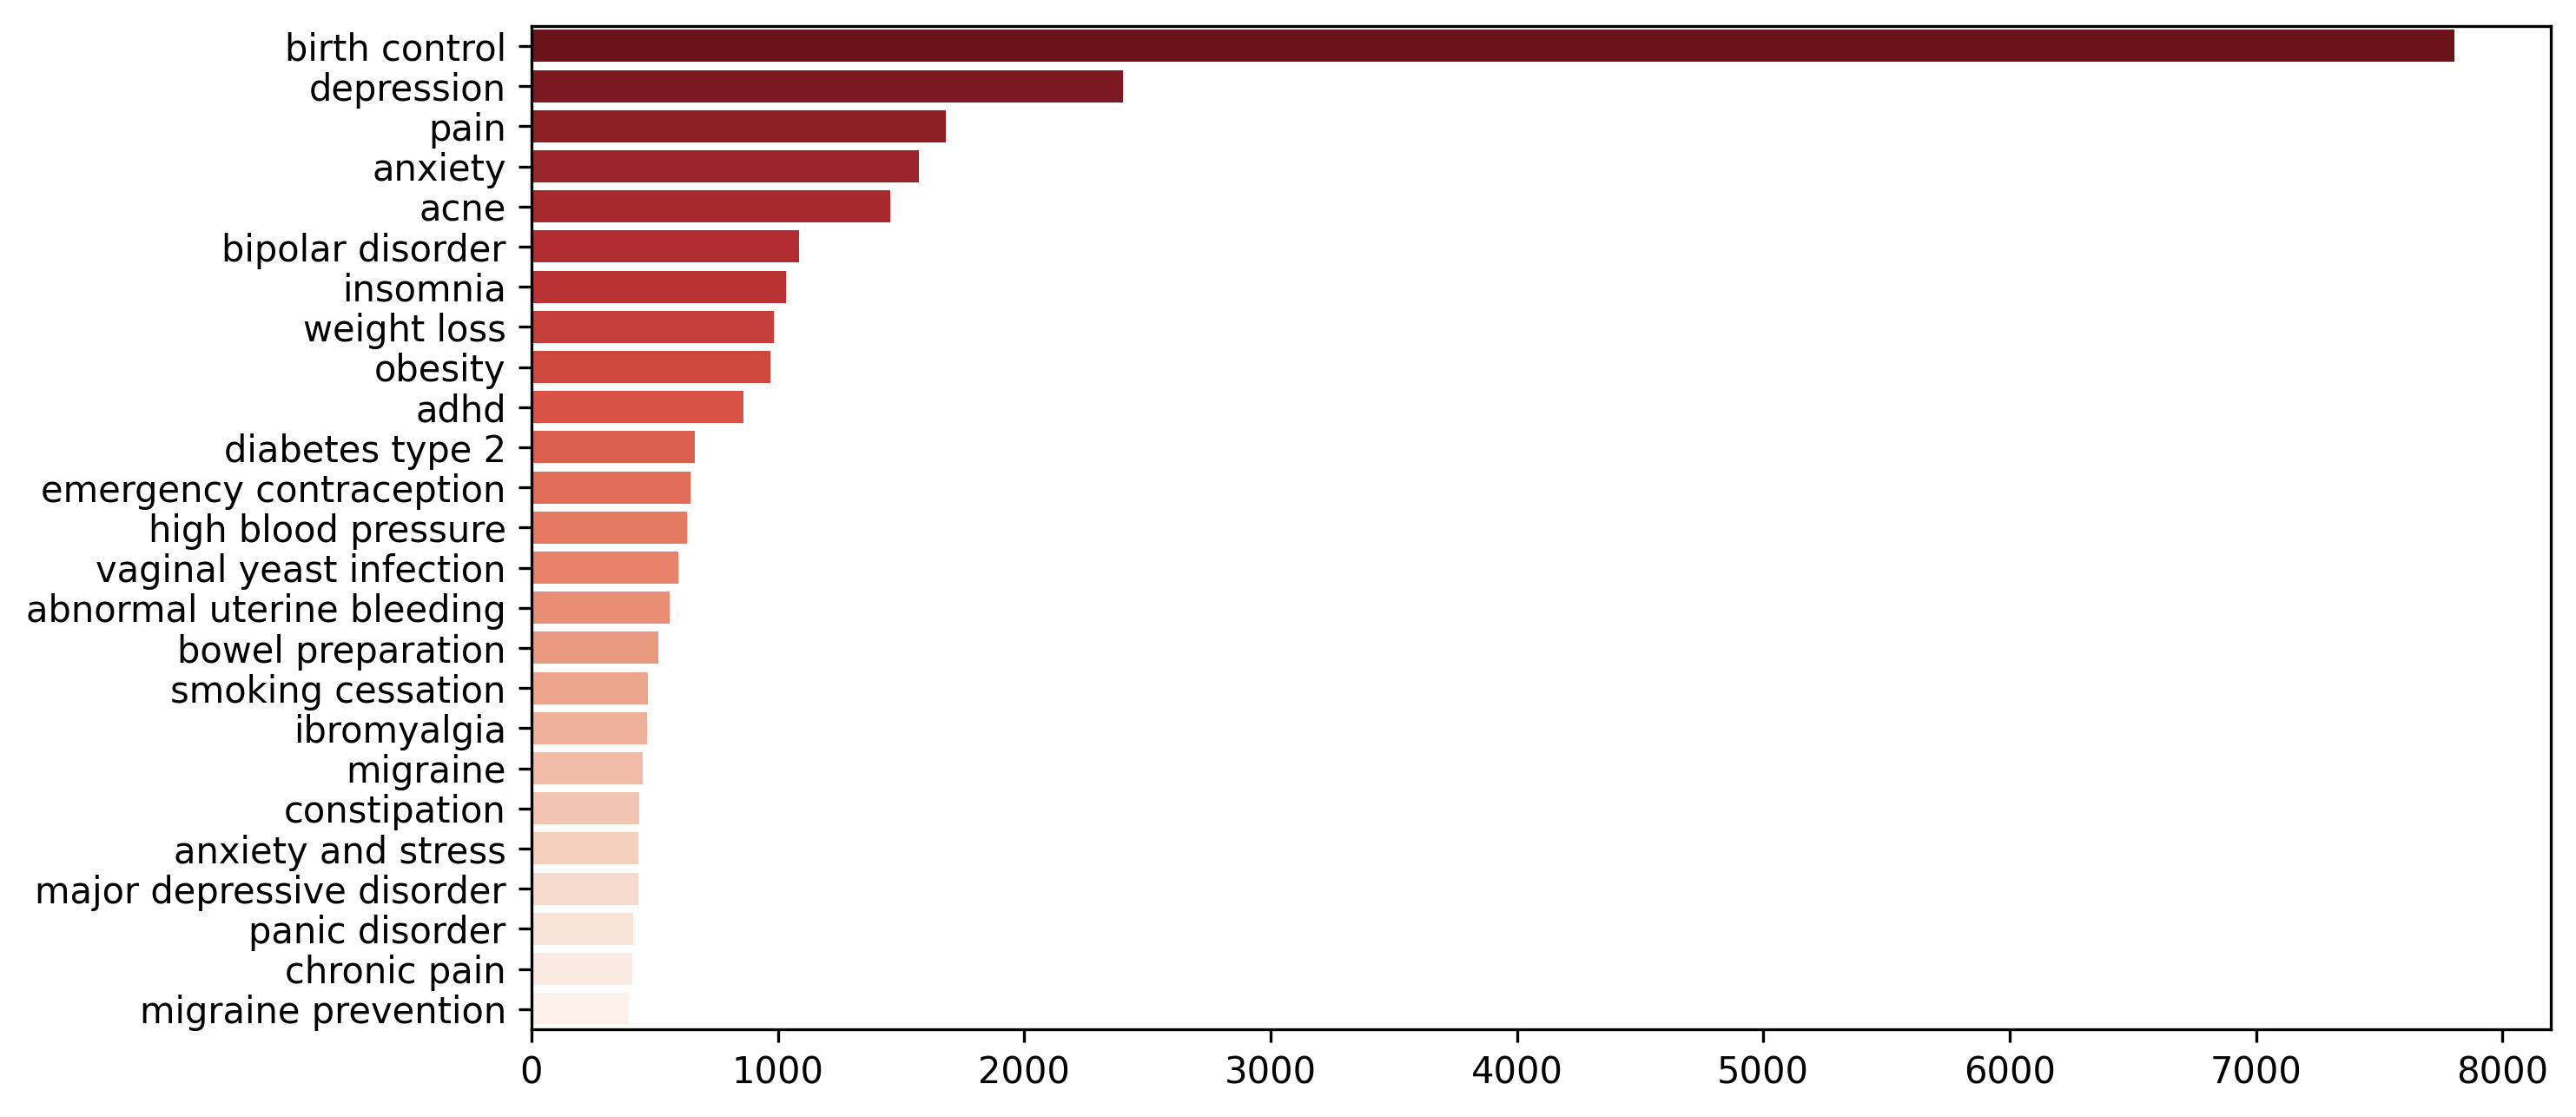

In [17]:
plt.figure('figsize', (10, 5), dpi=300)
g = sns.barplot(y=data['use_case_for_drug'].value_counts()[:25].index, 
                x=data['use_case_for_drug'].value_counts()[:25].values, 
                palette='Reds_r')

### _Drug Names_

In [18]:
data2 = data.copy()

In [19]:
drug_names = data2['name_of_drug']

In [20]:
def clean_names(text):
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

In [21]:
for i, name in enumerate(drug_names):
    drug_names[i] = clean_names(name)
    

data2['name_of_drug'] = drug_names    

/tmp/ipykernel_11111/2093588621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_names[i] = clean_names(name)


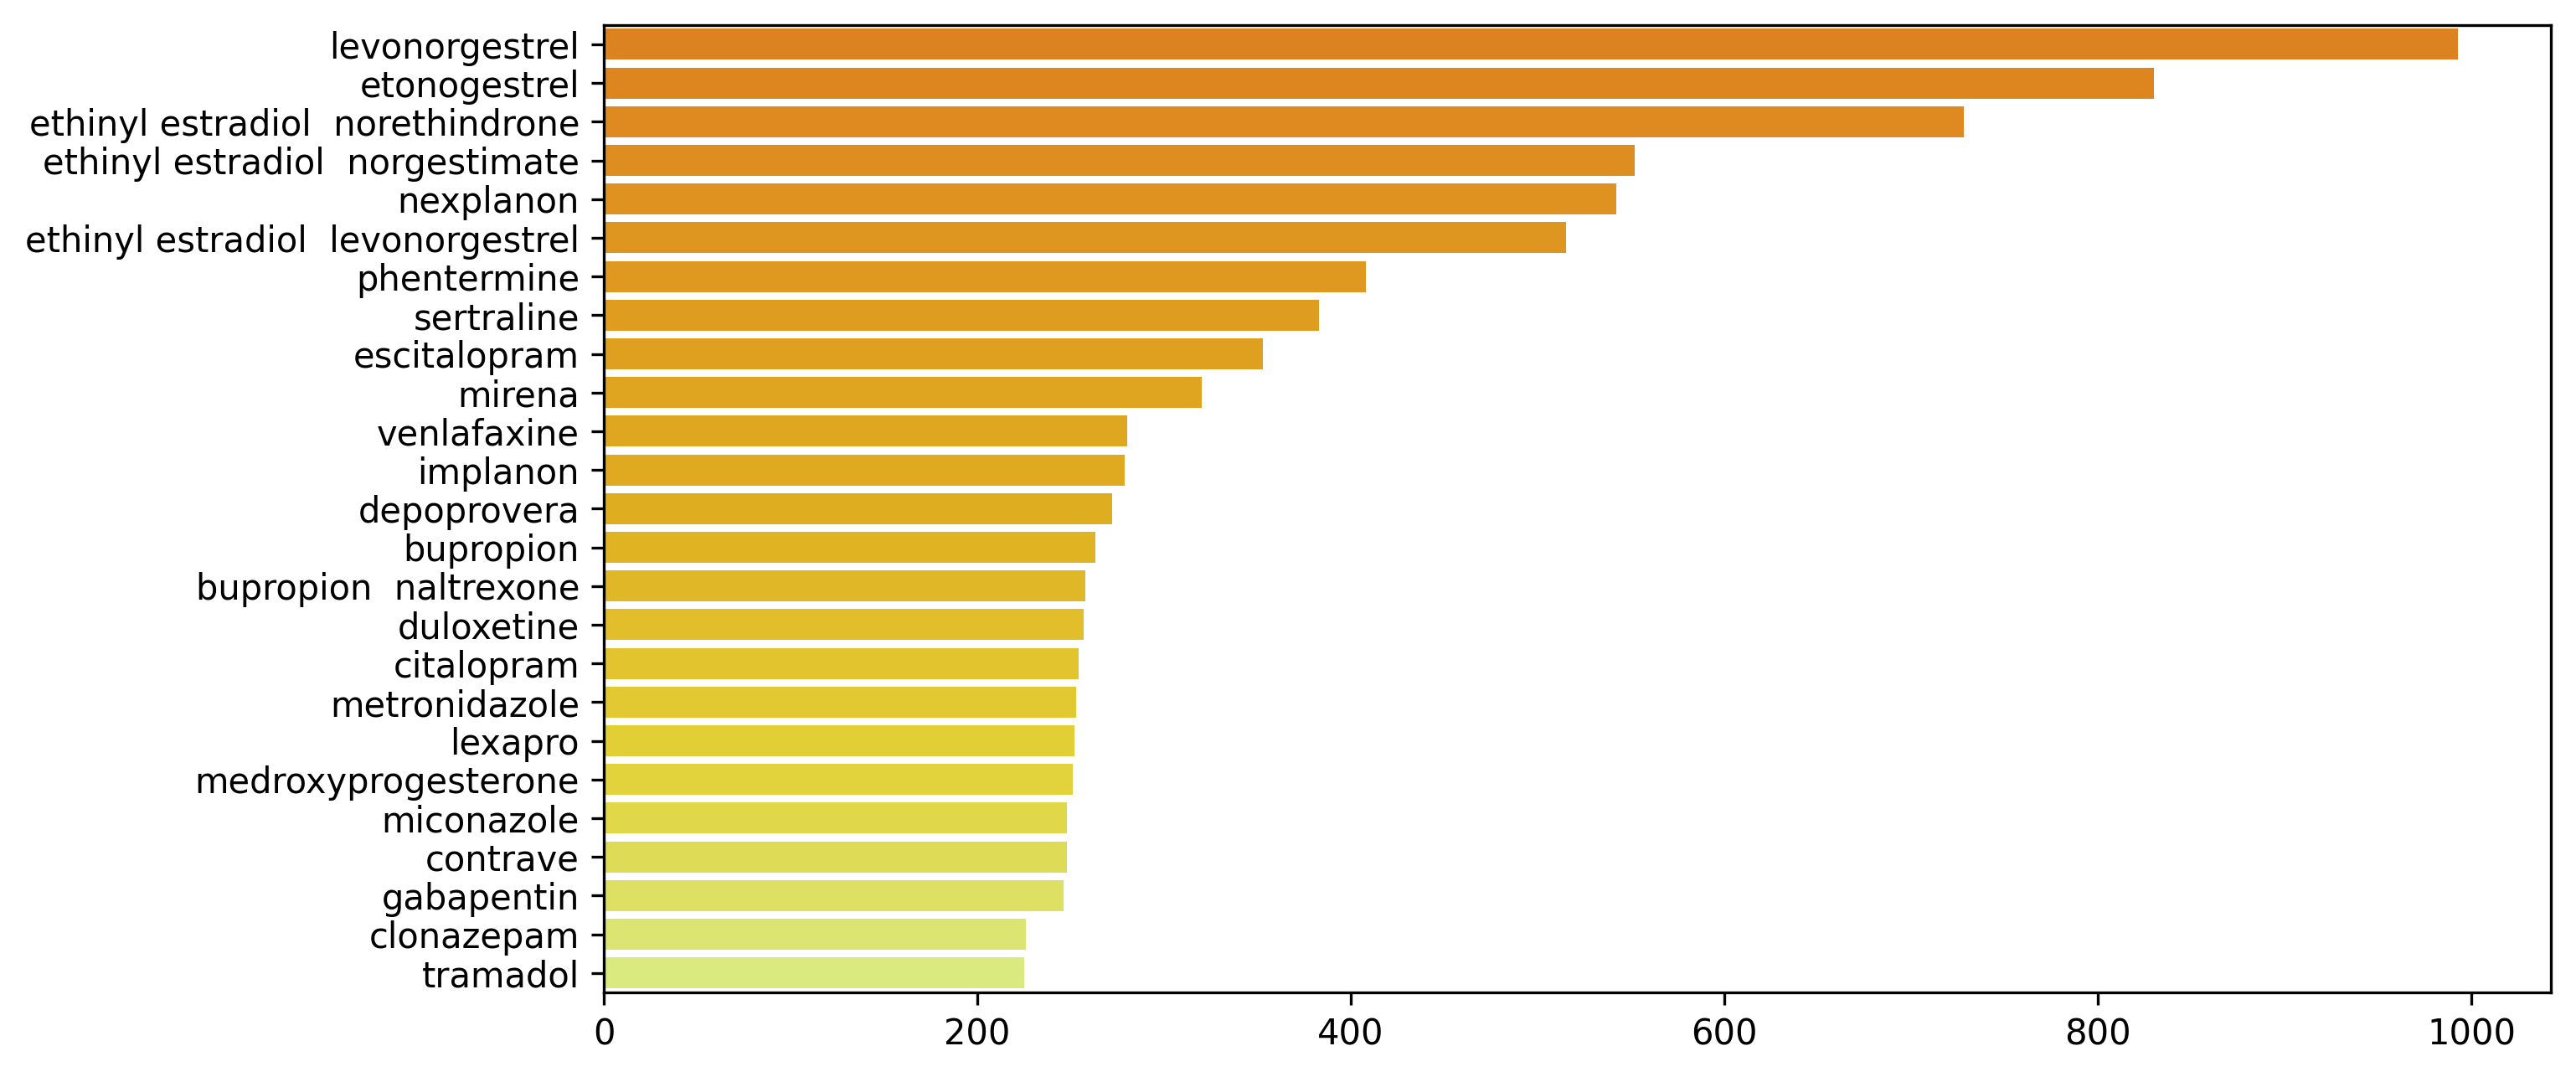

In [22]:
plt.figure('figsize', (10, 5), dpi=300)
g = sns.barplot(y=data2['name_of_drug'].value_counts()[:25].index, 
                x=data2['name_of_drug'].value_counts()[:25].values, 
                palette='Wistia_r')

### _Reviews_

In [23]:
data3 = data2.copy()

In [24]:
reviews = data3['review_by_patient']

In [25]:
def clean_sentences(text):
    text = text.lower()
    
    text = re.sub(r"\&#039;", r"""'""", text)
    text = re.sub(r"\&amp;", "and", text)
    text = re.sub(r"\\r\n\r\n", "", text)
    text = re.sub(r"\!", "", text)
    text = re.sub(r"\&#33;", "", text)
    text = re.sub(r"\&#34;", "", text)
    text = re.sub(r"\&#35;", "", text)
    text = re.sub(r"\&#36;", "", text)
    text = re.sub(r"\&#37;", "", text)
    text = re.sub(r"\&#38;", "", text)
    text = re.sub(r"\&#39;", "", text)
    text = re.sub(r"\&#40;", "", text)
    text = re.sub(r"\&#41;", "", text)
    text = re.sub(r"\&#42;", "", text)
    text = re.sub(r"\&#43;", "", text)
    text = re.sub(r"\&#44;", "", text)
    text = re.sub(r"\&#45;", "", text)
    text = re.sub(r"\&#46;", "", text)
    text = re.sub(r"\&#47;", "", text)
    text = re.sub(r"\&#58;", "", text)
    text = re.sub(r"\&#59;", "", text)    
    
    
    return text

In [26]:
for i, review in enumerate(reviews):
    reviews[i] = clean_sentences(review)

/tmp/ipykernel_11111/1642609134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[i] = clean_sentences(review)


In [27]:
reviews[98]

'"i have severe psoriatic arthritis and i\'ve had it since i was 18. i\'ve been on remicade for almost 10 years and i have almost no pain. my joints get a little stiff close to my infusion but that\'s it. it is my miracle drug and i owe my life to it. i would be crippled without it."'

# _BERT Implimentation for Sentiment Analysis_

In [28]:
data4 = data3.copy()

In [29]:
sentiment_classifier = TFAutoModelForSequenceClassification.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

2022-10-31 11:11:04.867253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 11:11:04.867392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 11:11:04.867441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-31 11:11:04.867476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-31 11:11:04.867527: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [30]:
tokenizer_bert = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [31]:
review_sentiments = []
i = 0

for review in reviews:
    review_token = tokenizer_bert.encode(review[:320],return_tensors='tf' )
    result = sentiment_classifier(review_token)
    review_sentiments.append(result.logits)
    print('{} done'.format(i))
    i+=1

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done
101 done
102 done
103 done
104 done
105 done
106 done
107 done
108 done
109 done
110 done
111 done
112 done
113 done
114 done
115 done
116 done
117 done
118 done
119 done
120 done
121 done
122 done
123

923 done
924 done
925 done
926 done
927 done
928 done
929 done
930 done
931 done
932 done
933 done
934 done
935 done
936 done
937 done
938 done
939 done
940 done
941 done
942 done
943 done
944 done
945 done
946 done
947 done
948 done
949 done
950 done
951 done
952 done
953 done
954 done
955 done
956 done
957 done
958 done
959 done
960 done
961 done
962 done
963 done
964 done
965 done
966 done
967 done
968 done
969 done
970 done
971 done
972 done
973 done
974 done
975 done
976 done
977 done
978 done
979 done
980 done
981 done
982 done
983 done
984 done
985 done
986 done
987 done
988 done
989 done
990 done
991 done
992 done
993 done
994 done
995 done
996 done
997 done
998 done
999 done
1000 done
1001 done
1002 done
1003 done
1004 done
1005 done
1006 done
1007 done
1008 done
1009 done
1010 done
1011 done
1012 done
1013 done
1014 done
1015 done
1016 done
1017 done
1018 done
1019 done
1020 done
1021 done
1022 done
1023 done
1024 done
1025 done
1026 done
1027 done
1028 done
1029 done
1030 do

1750 done
1751 done
1752 done
1753 done
1754 done
1755 done
1756 done
1757 done
1758 done
1759 done
1760 done
1761 done
1762 done
1763 done
1764 done
1765 done
1766 done
1767 done
1768 done
1769 done
1770 done
1771 done
1772 done
1773 done
1774 done
1775 done
1776 done
1777 done
1778 done
1779 done
1780 done
1781 done
1782 done
1783 done
1784 done
1785 done
1786 done
1787 done
1788 done
1789 done
1790 done
1791 done
1792 done
1793 done
1794 done
1795 done
1796 done
1797 done
1798 done
1799 done
1800 done
1801 done
1802 done
1803 done
1804 done
1805 done
1806 done
1807 done
1808 done
1809 done
1810 done
1811 done
1812 done
1813 done
1814 done
1815 done
1816 done
1817 done
1818 done
1819 done
1820 done
1821 done
1822 done
1823 done
1824 done
1825 done
1826 done
1827 done
1828 done
1829 done
1830 done
1831 done
1832 done
1833 done
1834 done
1835 done
1836 done
1837 done
1838 done
1839 done
1840 done
1841 done
1842 done
1843 done
1844 done
1845 done
1846 done
1847 done
1848 done
1849 done


2570 done
2571 done
2572 done
2573 done
2574 done
2575 done
2576 done
2577 done
2578 done
2579 done
2580 done
2581 done
2582 done
2583 done
2584 done
2585 done
2586 done
2587 done
2588 done
2589 done
2590 done
2591 done
2592 done
2593 done
2594 done
2595 done
2596 done
2597 done
2598 done
2599 done
2600 done
2601 done
2602 done
2603 done
2604 done
2605 done
2606 done
2607 done
2608 done
2609 done
2610 done
2611 done
2612 done
2613 done
2614 done
2615 done
2616 done
2617 done
2618 done
2619 done
2620 done
2621 done
2622 done
2623 done
2624 done
2625 done
2626 done
2627 done
2628 done
2629 done
2630 done
2631 done
2632 done
2633 done
2634 done
2635 done
2636 done
2637 done
2638 done
2639 done
2640 done
2641 done
2642 done
2643 done
2644 done
2645 done
2646 done
2647 done
2648 done
2649 done
2650 done
2651 done
2652 done
2653 done
2654 done
2655 done
2656 done
2657 done
2658 done
2659 done
2660 done
2661 done
2662 done
2663 done
2664 done
2665 done
2666 done
2667 done
2668 done
2669 done


3390 done
3391 done
3392 done
3393 done
3394 done
3395 done
3396 done
3397 done
3398 done
3399 done
3400 done
3401 done
3402 done
3403 done
3404 done
3405 done
3406 done
3407 done
3408 done
3409 done
3410 done
3411 done
3412 done
3413 done
3414 done
3415 done
3416 done
3417 done
3418 done
3419 done
3420 done
3421 done
3422 done
3423 done
3424 done
3425 done
3426 done
3427 done
3428 done
3429 done
3430 done
3431 done
3432 done
3433 done
3434 done
3435 done
3436 done
3437 done
3438 done
3439 done
3440 done
3441 done
3442 done
3443 done
3444 done
3445 done
3446 done
3447 done
3448 done
3449 done
3450 done
3451 done
3452 done
3453 done
3454 done
3455 done
3456 done
3457 done
3458 done
3459 done
3460 done
3461 done
3462 done
3463 done
3464 done
3465 done
3466 done
3467 done
3468 done
3469 done
3470 done
3471 done
3472 done
3473 done
3474 done
3475 done
3476 done
3477 done
3478 done
3479 done
3480 done
3481 done
3482 done
3483 done
3484 done
3485 done
3486 done
3487 done
3488 done
3489 done


4210 done
4211 done
4212 done
4213 done
4214 done
4215 done
4216 done
4217 done
4218 done
4219 done
4220 done
4221 done
4222 done
4223 done
4224 done
4225 done
4226 done
4227 done
4228 done
4229 done
4230 done
4231 done
4232 done
4233 done
4234 done
4235 done
4236 done
4237 done
4238 done
4239 done
4240 done
4241 done
4242 done
4243 done
4244 done
4245 done
4246 done
4247 done
4248 done
4249 done
4250 done
4251 done
4252 done
4253 done
4254 done
4255 done
4256 done
4257 done
4258 done
4259 done
4260 done
4261 done
4262 done
4263 done
4264 done
4265 done
4266 done
4267 done
4268 done
4269 done
4270 done
4271 done
4272 done
4273 done
4274 done
4275 done
4276 done
4277 done
4278 done
4279 done
4280 done
4281 done
4282 done
4283 done
4284 done
4285 done
4286 done
4287 done
4288 done
4289 done
4290 done
4291 done
4292 done
4293 done
4294 done
4295 done
4296 done
4297 done
4298 done
4299 done
4300 done
4301 done
4302 done
4303 done
4304 done
4305 done
4306 done
4307 done
4308 done
4309 done


5030 done
5031 done
5032 done
5033 done
5034 done
5035 done
5036 done
5037 done
5038 done
5039 done
5040 done
5041 done
5042 done
5043 done
5044 done
5045 done
5046 done
5047 done
5048 done
5049 done
5050 done
5051 done
5052 done
5053 done
5054 done
5055 done
5056 done
5057 done
5058 done
5059 done
5060 done
5061 done
5062 done
5063 done
5064 done
5065 done
5066 done
5067 done
5068 done
5069 done
5070 done
5071 done
5072 done
5073 done
5074 done
5075 done
5076 done
5077 done
5078 done
5079 done
5080 done
5081 done
5082 done
5083 done
5084 done
5085 done
5086 done
5087 done
5088 done
5089 done
5090 done
5091 done
5092 done
5093 done
5094 done
5095 done
5096 done
5097 done
5098 done
5099 done
5100 done
5101 done
5102 done
5103 done
5104 done
5105 done
5106 done
5107 done
5108 done
5109 done
5110 done
5111 done
5112 done
5113 done
5114 done
5115 done
5116 done
5117 done
5118 done
5119 done
5120 done
5121 done
5122 done
5123 done
5124 done
5125 done
5126 done
5127 done
5128 done
5129 done


5850 done
5851 done
5852 done
5853 done
5854 done
5855 done
5856 done
5857 done
5858 done
5859 done
5860 done
5861 done
5862 done
5863 done
5864 done
5865 done
5866 done
5867 done
5868 done
5869 done
5870 done
5871 done
5872 done
5873 done
5874 done
5875 done
5876 done
5877 done
5878 done
5879 done
5880 done
5881 done
5882 done
5883 done
5884 done
5885 done
5886 done
5887 done
5888 done
5889 done
5890 done
5891 done
5892 done
5893 done
5894 done
5895 done
5896 done
5897 done
5898 done
5899 done
5900 done
5901 done
5902 done
5903 done
5904 done
5905 done
5906 done
5907 done
5908 done
5909 done
5910 done
5911 done
5912 done
5913 done
5914 done
5915 done
5916 done
5917 done
5918 done
5919 done
5920 done
5921 done
5922 done
5923 done
5924 done
5925 done
5926 done
5927 done
5928 done
5929 done
5930 done
5931 done
5932 done
5933 done
5934 done
5935 done
5936 done
5937 done
5938 done
5939 done
5940 done
5941 done
5942 done
5943 done
5944 done
5945 done
5946 done
5947 done
5948 done
5949 done


6670 done
6671 done
6672 done
6673 done
6674 done
6675 done
6676 done
6677 done
6678 done
6679 done
6680 done
6681 done
6682 done
6683 done
6684 done
6685 done
6686 done
6687 done
6688 done
6689 done
6690 done
6691 done
6692 done
6693 done
6694 done
6695 done
6696 done
6697 done
6698 done
6699 done
6700 done
6701 done
6702 done
6703 done
6704 done
6705 done
6706 done
6707 done
6708 done
6709 done
6710 done
6711 done
6712 done
6713 done
6714 done
6715 done
6716 done
6717 done
6718 done
6719 done
6720 done
6721 done
6722 done
6723 done
6724 done
6725 done
6726 done
6727 done
6728 done
6729 done
6730 done
6731 done
6732 done
6733 done
6734 done
6735 done
6736 done
6737 done
6738 done
6739 done
6740 done
6741 done
6742 done
6743 done
6744 done
6745 done
6746 done
6747 done
6748 done
6749 done
6750 done
6751 done
6752 done
6753 done
6754 done
6755 done
6756 done
6757 done
6758 done
6759 done
6760 done
6761 done
6762 done
6763 done
6764 done
6765 done
6766 done
6767 done
6768 done
6769 done


7491 done
7492 done
7493 done
7494 done
7495 done
7496 done
7497 done
7498 done
7499 done
7500 done
7501 done
7502 done
7503 done
7504 done
7505 done
7506 done
7507 done
7508 done
7509 done
7510 done
7511 done
7512 done
7513 done
7514 done
7515 done
7516 done
7517 done
7518 done
7519 done
7520 done
7521 done
7522 done
7523 done
7524 done
7525 done
7526 done
7527 done
7528 done
7529 done
7530 done
7531 done
7532 done
7533 done
7534 done
7535 done
7536 done
7537 done
7538 done
7539 done
7540 done
7541 done
7542 done
7543 done
7544 done
7545 done
7546 done
7547 done
7548 done
7549 done
7550 done
7551 done
7552 done
7553 done
7554 done
7555 done
7556 done
7557 done
7558 done
7559 done
7560 done
7561 done
7562 done
7563 done
7564 done
7565 done
7566 done
7567 done
7568 done
7569 done
7570 done
7571 done
7572 done
7573 done
7574 done
7575 done
7576 done
7577 done
7578 done
7579 done
7580 done
7581 done
7582 done
7583 done
7584 done
7585 done
7586 done
7587 done
7588 done
7589 done
7590 done


8311 done
8312 done
8313 done
8314 done
8315 done
8316 done
8317 done
8318 done
8319 done
8320 done
8321 done
8322 done
8323 done
8324 done
8325 done
8326 done
8327 done
8328 done
8329 done
8330 done
8331 done
8332 done
8333 done
8334 done
8335 done
8336 done
8337 done
8338 done
8339 done
8340 done
8341 done
8342 done
8343 done
8344 done
8345 done
8346 done
8347 done
8348 done
8349 done
8350 done
8351 done
8352 done
8353 done
8354 done
8355 done
8356 done
8357 done
8358 done
8359 done
8360 done
8361 done
8362 done
8363 done
8364 done
8365 done
8366 done
8367 done
8368 done
8369 done
8370 done
8371 done
8372 done
8373 done
8374 done
8375 done
8376 done
8377 done
8378 done
8379 done
8380 done
8381 done
8382 done
8383 done
8384 done
8385 done
8386 done
8387 done
8388 done
8389 done
8390 done
8391 done
8392 done
8393 done
8394 done
8395 done
8396 done
8397 done
8398 done
8399 done
8400 done
8401 done
8402 done
8403 done
8404 done
8405 done
8406 done
8407 done
8408 done
8409 done
8410 done


9131 done
9132 done
9133 done
9134 done
9135 done
9136 done
9137 done
9138 done
9139 done
9140 done
9141 done
9142 done
9143 done
9144 done
9145 done
9146 done
9147 done
9148 done
9149 done
9150 done
9151 done
9152 done
9153 done
9154 done
9155 done
9156 done
9157 done
9158 done
9159 done
9160 done
9161 done
9162 done
9163 done
9164 done
9165 done
9166 done
9167 done
9168 done
9169 done
9170 done
9171 done
9172 done
9173 done
9174 done
9175 done
9176 done
9177 done
9178 done
9179 done
9180 done
9181 done
9182 done
9183 done
9184 done
9185 done
9186 done
9187 done
9188 done
9189 done
9190 done
9191 done
9192 done
9193 done
9194 done
9195 done
9196 done
9197 done
9198 done
9199 done
9200 done
9201 done
9202 done
9203 done
9204 done
9205 done
9206 done
9207 done
9208 done
9209 done
9210 done
9211 done
9212 done
9213 done
9214 done
9215 done
9216 done
9217 done
9218 done
9219 done
9220 done
9221 done
9222 done
9223 done
9224 done
9225 done
9226 done
9227 done
9228 done
9229 done
9230 done


9951 done
9952 done
9953 done
9954 done
9955 done
9956 done
9957 done
9958 done
9959 done
9960 done
9961 done
9962 done
9963 done
9964 done
9965 done
9966 done
9967 done
9968 done
9969 done
9970 done
9971 done
9972 done
9973 done
9974 done
9975 done
9976 done
9977 done
9978 done
9979 done
9980 done
9981 done
9982 done
9983 done
9984 done
9985 done
9986 done
9987 done
9988 done
9989 done
9990 done
9991 done
9992 done
9993 done
9994 done
9995 done
9996 done
9997 done
9998 done
9999 done
10000 done
10001 done
10002 done
10003 done
10004 done
10005 done
10006 done
10007 done
10008 done
10009 done
10010 done
10011 done
10012 done
10013 done
10014 done
10015 done
10016 done
10017 done
10018 done
10019 done
10020 done
10021 done
10022 done
10023 done
10024 done
10025 done
10026 done
10027 done
10028 done
10029 done
10030 done
10031 done
10032 done
10033 done
10034 done
10035 done
10036 done
10037 done
10038 done
10039 done
10040 done
10041 done
10042 done
10043 done
10044 done
10045 done
1004

10701 done
10702 done
10703 done
10704 done
10705 done
10706 done
10707 done
10708 done
10709 done
10710 done
10711 done
10712 done
10713 done
10714 done
10715 done
10716 done
10717 done
10718 done
10719 done
10720 done
10721 done
10722 done
10723 done
10724 done
10725 done
10726 done
10727 done
10728 done
10729 done
10730 done
10731 done
10732 done
10733 done
10734 done
10735 done
10736 done
10737 done
10738 done
10739 done
10740 done
10741 done
10742 done
10743 done
10744 done
10745 done
10746 done
10747 done
10748 done
10749 done
10750 done
10751 done
10752 done
10753 done
10754 done
10755 done
10756 done
10757 done
10758 done
10759 done
10760 done
10761 done
10762 done
10763 done
10764 done
10765 done
10766 done
10767 done
10768 done
10769 done
10770 done
10771 done
10772 done
10773 done
10774 done
10775 done
10776 done
10777 done
10778 done
10779 done
10780 done
10781 done
10782 done
10783 done
10784 done
10785 done
10786 done
10787 done
10788 done
10789 done
10790 done
10791 done

11446 done
11447 done
11448 done
11449 done
11450 done
11451 done
11452 done
11453 done
11454 done
11455 done
11456 done
11457 done
11458 done
11459 done
11460 done
11461 done
11462 done
11463 done
11464 done
11465 done
11466 done
11467 done
11468 done
11469 done
11470 done
11471 done
11472 done
11473 done
11474 done
11475 done
11476 done
11477 done
11478 done
11479 done
11480 done
11481 done
11482 done
11483 done
11484 done
11485 done
11486 done
11487 done
11488 done
11489 done
11490 done
11491 done
11492 done
11493 done
11494 done
11495 done
11496 done
11497 done
11498 done
11499 done
11500 done
11501 done
11502 done
11503 done
11504 done
11505 done
11506 done
11507 done
11508 done
11509 done
11510 done
11511 done
11512 done
11513 done
11514 done
11515 done
11516 done
11517 done
11518 done
11519 done
11520 done
11521 done
11522 done
11523 done
11524 done
11525 done
11526 done
11527 done
11528 done
11529 done
11530 done
11531 done
11532 done
11533 done
11534 done
11535 done
11536 done

12191 done
12192 done
12193 done
12194 done
12195 done
12196 done
12197 done
12198 done
12199 done
12200 done
12201 done
12202 done
12203 done
12204 done
12205 done
12206 done
12207 done
12208 done
12209 done
12210 done
12211 done
12212 done
12213 done
12214 done
12215 done
12216 done
12217 done
12218 done
12219 done
12220 done
12221 done
12222 done
12223 done
12224 done
12225 done
12226 done
12227 done
12228 done
12229 done
12230 done
12231 done
12232 done
12233 done
12234 done
12235 done
12236 done
12237 done
12238 done
12239 done
12240 done
12241 done
12242 done
12243 done
12244 done
12245 done
12246 done
12247 done
12248 done
12249 done
12250 done
12251 done
12252 done
12253 done
12254 done
12255 done
12256 done
12257 done
12258 done
12259 done
12260 done
12261 done
12262 done
12263 done
12264 done
12265 done
12266 done
12267 done
12268 done
12269 done
12270 done
12271 done
12272 done
12273 done
12274 done
12275 done
12276 done
12277 done
12278 done
12279 done
12280 done
12281 done

12936 done
12937 done
12938 done
12939 done
12940 done
12941 done
12942 done
12943 done
12944 done
12945 done
12946 done
12947 done
12948 done
12949 done
12950 done
12951 done
12952 done
12953 done
12954 done
12955 done
12956 done
12957 done
12958 done
12959 done
12960 done
12961 done
12962 done
12963 done
12964 done
12965 done
12966 done
12967 done
12968 done
12969 done
12970 done
12971 done
12972 done
12973 done
12974 done
12975 done
12976 done
12977 done
12978 done
12979 done
12980 done
12981 done
12982 done
12983 done
12984 done
12985 done
12986 done
12987 done
12988 done
12989 done
12990 done
12991 done
12992 done
12993 done
12994 done
12995 done
12996 done
12997 done
12998 done
12999 done
13000 done
13001 done
13002 done
13003 done
13004 done
13005 done
13006 done
13007 done
13008 done
13009 done
13010 done
13011 done
13012 done
13013 done
13014 done
13015 done
13016 done
13017 done
13018 done
13019 done
13020 done
13021 done
13022 done
13023 done
13024 done
13025 done
13026 done

13682 done
13683 done
13684 done
13685 done
13686 done
13687 done
13688 done
13689 done
13690 done
13691 done
13692 done
13693 done
13694 done
13695 done
13696 done
13697 done
13698 done
13699 done
13700 done
13701 done
13702 done
13703 done
13704 done
13705 done
13706 done
13707 done
13708 done
13709 done
13710 done
13711 done
13712 done
13713 done
13714 done
13715 done
13716 done
13717 done
13718 done
13719 done
13720 done
13721 done
13722 done
13723 done
13724 done
13725 done
13726 done
13727 done
13728 done
13729 done
13730 done
13731 done
13732 done
13733 done
13734 done
13735 done
13736 done
13737 done
13738 done
13739 done
13740 done
13741 done
13742 done
13743 done
13744 done
13745 done
13746 done
13747 done
13748 done
13749 done
13750 done
13751 done
13752 done
13753 done
13754 done
13755 done
13756 done
13757 done
13758 done
13759 done
13760 done
13761 done
13762 done
13763 done
13764 done
13765 done
13766 done
13767 done
13768 done
13769 done
13770 done
13771 done
13772 done

14427 done
14428 done
14429 done
14430 done
14431 done
14432 done
14433 done
14434 done
14435 done
14436 done
14437 done
14438 done
14439 done
14440 done
14441 done
14442 done
14443 done
14444 done
14445 done
14446 done
14447 done
14448 done
14449 done
14450 done
14451 done
14452 done
14453 done
14454 done
14455 done
14456 done
14457 done
14458 done
14459 done
14460 done
14461 done
14462 done
14463 done
14464 done
14465 done
14466 done
14467 done
14468 done
14469 done
14470 done
14471 done
14472 done
14473 done
14474 done
14475 done
14476 done
14477 done
14478 done
14479 done
14480 done
14481 done
14482 done
14483 done
14484 done
14485 done
14486 done
14487 done
14488 done
14489 done
14490 done
14491 done
14492 done
14493 done
14494 done
14495 done
14496 done
14497 done
14498 done
14499 done
14500 done
14501 done
14502 done
14503 done
14504 done
14505 done
14506 done
14507 done
14508 done
14509 done
14510 done
14511 done
14512 done
14513 done
14514 done
14515 done
14516 done
14517 done

15172 done
15173 done
15174 done
15175 done
15176 done
15177 done
15178 done
15179 done
15180 done
15181 done
15182 done
15183 done
15184 done
15185 done
15186 done
15187 done
15188 done
15189 done
15190 done
15191 done
15192 done
15193 done
15194 done
15195 done
15196 done
15197 done
15198 done
15199 done
15200 done
15201 done
15202 done
15203 done
15204 done
15205 done
15206 done
15207 done
15208 done
15209 done
15210 done
15211 done
15212 done
15213 done
15214 done
15215 done
15216 done
15217 done
15218 done
15219 done
15220 done
15221 done
15222 done
15223 done
15224 done
15225 done
15226 done
15227 done
15228 done
15229 done
15230 done
15231 done
15232 done
15233 done
15234 done
15235 done
15236 done
15237 done
15238 done
15239 done
15240 done
15241 done
15242 done
15243 done
15244 done
15245 done
15246 done
15247 done
15248 done
15249 done
15250 done
15251 done
15252 done
15253 done
15254 done
15255 done
15256 done
15257 done
15258 done
15259 done
15260 done
15261 done
15262 done

15917 done
15918 done
15919 done
15920 done
15921 done
15922 done
15923 done
15924 done
15925 done
15926 done
15927 done
15928 done
15929 done
15930 done
15931 done
15932 done
15933 done
15934 done
15935 done
15936 done
15937 done
15938 done
15939 done
15940 done
15941 done
15942 done
15943 done
15944 done
15945 done
15946 done
15947 done
15948 done
15949 done
15950 done
15951 done
15952 done
15953 done
15954 done
15955 done
15956 done
15957 done
15958 done
15959 done
15960 done
15961 done
15962 done
15963 done
15964 done
15965 done
15966 done
15967 done
15968 done
15969 done
15970 done
15971 done
15972 done
15973 done
15974 done
15975 done
15976 done
15977 done
15978 done
15979 done
15980 done
15981 done
15982 done
15983 done
15984 done
15985 done
15986 done
15987 done
15988 done
15989 done
15990 done
15991 done
15992 done
15993 done
15994 done
15995 done
15996 done
15997 done
15998 done
15999 done
16000 done
16001 done
16002 done
16003 done
16004 done
16005 done
16006 done
16007 done

16662 done
16663 done
16664 done
16665 done
16666 done
16667 done
16668 done
16669 done
16670 done
16671 done
16672 done
16673 done
16674 done
16675 done
16676 done
16677 done
16678 done
16679 done
16680 done
16681 done
16682 done
16683 done
16684 done
16685 done
16686 done
16687 done
16688 done
16689 done
16690 done
16691 done
16692 done
16693 done
16694 done
16695 done
16696 done
16697 done
16698 done
16699 done
16700 done
16701 done
16702 done
16703 done
16704 done
16705 done
16706 done
16707 done
16708 done
16709 done
16710 done
16711 done
16712 done
16713 done
16714 done
16715 done
16716 done
16717 done
16718 done
16719 done
16720 done
16721 done
16722 done
16723 done
16724 done
16725 done
16726 done
16727 done
16728 done
16729 done
16730 done
16731 done
16732 done
16733 done
16734 done
16735 done
16736 done
16737 done
16738 done
16739 done
16740 done
16741 done
16742 done
16743 done
16744 done
16745 done
16746 done
16747 done
16748 done
16749 done
16750 done
16751 done
16752 done

17408 done
17409 done
17410 done
17411 done
17412 done
17413 done
17414 done
17415 done
17416 done
17417 done
17418 done
17419 done
17420 done
17421 done
17422 done
17423 done
17424 done
17425 done
17426 done
17427 done
17428 done
17429 done
17430 done
17431 done
17432 done
17433 done
17434 done
17435 done
17436 done
17437 done
17438 done
17439 done
17440 done
17441 done
17442 done
17443 done
17444 done
17445 done
17446 done
17447 done
17448 done
17449 done
17450 done
17451 done
17452 done
17453 done
17454 done
17455 done
17456 done
17457 done
17458 done
17459 done
17460 done
17461 done
17462 done
17463 done
17464 done
17465 done
17466 done
17467 done
17468 done
17469 done
17470 done
17471 done
17472 done
17473 done
17474 done
17475 done
17476 done
17477 done
17478 done
17479 done
17480 done
17481 done
17482 done
17483 done
17484 done
17485 done
17486 done
17487 done
17488 done
17489 done
17490 done
17491 done
17492 done
17493 done
17494 done
17495 done
17496 done
17497 done
17498 done

18153 done
18154 done
18155 done
18156 done
18157 done
18158 done
18159 done
18160 done
18161 done
18162 done
18163 done
18164 done
18165 done
18166 done
18167 done
18168 done
18169 done
18170 done
18171 done
18172 done
18173 done
18174 done
18175 done
18176 done
18177 done
18178 done
18179 done
18180 done
18181 done
18182 done
18183 done
18184 done
18185 done
18186 done
18187 done
18188 done
18189 done
18190 done
18191 done
18192 done
18193 done
18194 done
18195 done
18196 done
18197 done
18198 done
18199 done
18200 done
18201 done
18202 done
18203 done
18204 done
18205 done
18206 done
18207 done
18208 done
18209 done
18210 done
18211 done
18212 done
18213 done
18214 done
18215 done
18216 done
18217 done
18218 done
18219 done
18220 done
18221 done
18222 done
18223 done
18224 done
18225 done
18226 done
18227 done
18228 done
18229 done
18230 done
18231 done
18232 done
18233 done
18234 done
18235 done
18236 done
18237 done
18238 done
18239 done
18240 done
18241 done
18242 done
18243 done

18898 done
18899 done
18900 done
18901 done
18902 done
18903 done
18904 done
18905 done
18906 done
18907 done
18908 done
18909 done
18910 done
18911 done
18912 done
18913 done
18914 done
18915 done
18916 done
18917 done
18918 done
18919 done
18920 done
18921 done
18922 done
18923 done
18924 done
18925 done
18926 done
18927 done
18928 done
18929 done
18930 done
18931 done
18932 done
18933 done
18934 done
18935 done
18936 done
18937 done
18938 done
18939 done
18940 done
18941 done
18942 done
18943 done
18944 done
18945 done
18946 done
18947 done
18948 done
18949 done
18950 done
18951 done
18952 done
18953 done
18954 done
18955 done
18956 done
18957 done
18958 done
18959 done
18960 done
18961 done
18962 done
18963 done
18964 done
18965 done
18966 done
18967 done
18968 done
18969 done
18970 done
18971 done
18972 done
18973 done
18974 done
18975 done
18976 done
18977 done
18978 done
18979 done
18980 done
18981 done
18982 done
18983 done
18984 done
18985 done
18986 done
18987 done
18988 done

19643 done
19644 done
19645 done
19646 done
19647 done
19648 done
19649 done
19650 done
19651 done
19652 done
19653 done
19654 done
19655 done
19656 done
19657 done
19658 done
19659 done
19660 done
19661 done
19662 done
19663 done
19664 done
19665 done
19666 done
19667 done
19668 done
19669 done
19670 done
19671 done
19672 done
19673 done
19674 done
19675 done
19676 done
19677 done
19678 done
19679 done
19680 done
19681 done
19682 done
19683 done
19684 done
19685 done
19686 done
19687 done
19688 done
19689 done
19690 done
19691 done
19692 done
19693 done
19694 done
19695 done
19696 done
19697 done
19698 done
19699 done
19700 done
19701 done
19702 done
19703 done
19704 done
19705 done
19706 done
19707 done
19708 done
19709 done
19710 done
19711 done
19712 done
19713 done
19714 done
19715 done
19716 done
19717 done
19718 done
19719 done
19720 done
19721 done
19722 done
19723 done
19724 done
19725 done
19726 done
19727 done
19728 done
19729 done
19730 done
19731 done
19732 done
19733 done

20388 done
20389 done
20390 done
20391 done
20392 done
20393 done
20394 done
20395 done
20396 done
20397 done
20398 done
20399 done
20400 done
20401 done
20402 done
20403 done
20404 done
20405 done
20406 done
20407 done
20408 done
20409 done
20410 done
20411 done
20412 done
20413 done
20414 done
20415 done
20416 done
20417 done
20418 done
20419 done
20420 done
20421 done
20422 done
20423 done
20424 done
20425 done
20426 done
20427 done
20428 done
20429 done
20430 done
20431 done
20432 done
20433 done
20434 done
20435 done
20436 done
20437 done
20438 done
20439 done
20440 done
20441 done
20442 done
20443 done
20444 done
20445 done
20446 done
20447 done
20448 done
20449 done
20450 done
20451 done
20452 done
20453 done
20454 done
20455 done
20456 done
20457 done
20458 done
20459 done
20460 done
20461 done
20462 done
20463 done
20464 done
20465 done
20466 done
20467 done
20468 done
20469 done
20470 done
20471 done
20472 done
20473 done
20474 done
20475 done
20476 done
20477 done
20478 done

21134 done
21135 done
21136 done
21137 done
21138 done
21139 done
21140 done
21141 done
21142 done
21143 done
21144 done
21145 done
21146 done
21147 done
21148 done
21149 done
21150 done
21151 done
21152 done
21153 done
21154 done
21155 done
21156 done
21157 done
21158 done
21159 done
21160 done
21161 done
21162 done
21163 done
21164 done
21165 done
21166 done
21167 done
21168 done
21169 done
21170 done
21171 done
21172 done
21173 done
21174 done
21175 done
21176 done
21177 done
21178 done
21179 done
21180 done
21181 done
21182 done
21183 done
21184 done
21185 done
21186 done
21187 done
21188 done
21189 done
21190 done
21191 done
21192 done
21193 done
21194 done
21195 done
21196 done
21197 done
21198 done
21199 done
21200 done
21201 done
21202 done
21203 done
21204 done
21205 done
21206 done
21207 done
21208 done
21209 done
21210 done
21211 done
21212 done
21213 done
21214 done
21215 done
21216 done
21217 done
21218 done
21219 done
21220 done
21221 done
21222 done
21223 done
21224 done

21879 done
21880 done
21881 done
21882 done
21883 done
21884 done
21885 done
21886 done
21887 done
21888 done
21889 done
21890 done
21891 done
21892 done
21893 done
21894 done
21895 done
21896 done
21897 done
21898 done
21899 done
21900 done
21901 done
21902 done
21903 done
21904 done
21905 done
21906 done
21907 done
21908 done
21909 done
21910 done
21911 done
21912 done
21913 done
21914 done
21915 done
21916 done
21917 done
21918 done
21919 done
21920 done
21921 done
21922 done
21923 done
21924 done
21925 done
21926 done
21927 done
21928 done
21929 done
21930 done
21931 done
21932 done
21933 done
21934 done
21935 done
21936 done
21937 done
21938 done
21939 done
21940 done
21941 done
21942 done
21943 done
21944 done
21945 done
21946 done
21947 done
21948 done
21949 done
21950 done
21951 done
21952 done
21953 done
21954 done
21955 done
21956 done
21957 done
21958 done
21959 done
21960 done
21961 done
21962 done
21963 done
21964 done
21965 done
21966 done
21967 done
21968 done
21969 done

22624 done
22625 done
22626 done
22627 done
22628 done
22629 done
22630 done
22631 done
22632 done
22633 done
22634 done
22635 done
22636 done
22637 done
22638 done
22639 done
22640 done
22641 done
22642 done
22643 done
22644 done
22645 done
22646 done
22647 done
22648 done
22649 done
22650 done
22651 done
22652 done
22653 done
22654 done
22655 done
22656 done
22657 done
22658 done
22659 done
22660 done
22661 done
22662 done
22663 done
22664 done
22665 done
22666 done
22667 done
22668 done
22669 done
22670 done
22671 done
22672 done
22673 done
22674 done
22675 done
22676 done
22677 done
22678 done
22679 done
22680 done
22681 done
22682 done
22683 done
22684 done
22685 done
22686 done
22687 done
22688 done
22689 done
22690 done
22691 done
22692 done
22693 done
22694 done
22695 done
22696 done
22697 done
22698 done
22699 done
22700 done
22701 done
22702 done
22703 done
22704 done
22705 done
22706 done
22707 done
22708 done
22709 done
22710 done
22711 done
22712 done
22713 done
22714 done

23369 done
23370 done
23371 done
23372 done
23373 done
23374 done
23375 done
23376 done
23377 done
23378 done
23379 done
23380 done
23381 done
23382 done
23383 done
23384 done
23385 done
23386 done
23387 done
23388 done
23389 done
23390 done
23391 done
23392 done
23393 done
23394 done
23395 done
23396 done
23397 done
23398 done
23399 done
23400 done
23401 done
23402 done
23403 done
23404 done
23405 done
23406 done
23407 done
23408 done
23409 done
23410 done
23411 done
23412 done
23413 done
23414 done
23415 done
23416 done
23417 done
23418 done
23419 done
23420 done
23421 done
23422 done
23423 done
23424 done
23425 done
23426 done
23427 done
23428 done
23429 done
23430 done
23431 done
23432 done
23433 done
23434 done
23435 done
23436 done
23437 done
23438 done
23439 done
23440 done
23441 done
23442 done
23443 done
23444 done
23445 done
23446 done
23447 done
23448 done
23449 done
23450 done
23451 done
23452 done
23453 done
23454 done
23455 done
23456 done
23457 done
23458 done
23459 done

24114 done
24115 done
24116 done
24117 done
24118 done
24119 done
24120 done
24121 done
24122 done
24123 done
24124 done
24125 done
24126 done
24127 done
24128 done
24129 done
24130 done
24131 done
24132 done
24133 done
24134 done
24135 done
24136 done
24137 done
24138 done
24139 done
24140 done
24141 done
24142 done
24143 done
24144 done
24145 done
24146 done
24147 done
24148 done
24149 done
24150 done
24151 done
24152 done
24153 done
24154 done
24155 done
24156 done
24157 done
24158 done
24159 done
24160 done
24161 done
24162 done
24163 done
24164 done
24165 done
24166 done
24167 done
24168 done
24169 done
24170 done
24171 done
24172 done
24173 done
24174 done
24175 done
24176 done
24177 done
24178 done
24179 done
24180 done
24181 done
24182 done
24183 done
24184 done
24185 done
24186 done
24187 done
24188 done
24189 done
24190 done
24191 done
24192 done
24193 done
24194 done
24195 done
24196 done
24197 done
24198 done
24199 done
24200 done
24201 done
24202 done
24203 done
24204 done

24859 done
24860 done
24861 done
24862 done
24863 done
24864 done
24865 done
24866 done
24867 done
24868 done
24869 done
24870 done
24871 done
24872 done
24873 done
24874 done
24875 done
24876 done
24877 done
24878 done
24879 done
24880 done
24881 done
24882 done
24883 done
24884 done
24885 done
24886 done
24887 done
24888 done
24889 done
24890 done
24891 done
24892 done
24893 done
24894 done
24895 done
24896 done
24897 done
24898 done
24899 done
24900 done
24901 done
24902 done
24903 done
24904 done
24905 done
24906 done
24907 done
24908 done
24909 done
24910 done
24911 done
24912 done
24913 done
24914 done
24915 done
24916 done
24917 done
24918 done
24919 done
24920 done
24921 done
24922 done
24923 done
24924 done
24925 done
24926 done
24927 done
24928 done
24929 done
24930 done
24931 done
24932 done
24933 done
24934 done
24935 done
24936 done
24937 done
24938 done
24939 done
24940 done
24941 done
24942 done
24943 done
24944 done
24945 done
24946 done
24947 done
24948 done
24949 done

25604 done
25605 done
25606 done
25607 done
25608 done
25609 done
25610 done
25611 done
25612 done
25613 done
25614 done
25615 done
25616 done
25617 done
25618 done
25619 done
25620 done
25621 done
25622 done
25623 done
25624 done
25625 done
25626 done
25627 done
25628 done
25629 done
25630 done
25631 done
25632 done
25633 done
25634 done
25635 done
25636 done
25637 done
25638 done
25639 done
25640 done
25641 done
25642 done
25643 done
25644 done
25645 done
25646 done
25647 done
25648 done
25649 done
25650 done
25651 done
25652 done
25653 done
25654 done
25655 done
25656 done
25657 done
25658 done
25659 done
25660 done
25661 done
25662 done
25663 done
25664 done
25665 done
25666 done
25667 done
25668 done
25669 done
25670 done
25671 done
25672 done
25673 done
25674 done
25675 done
25676 done
25677 done
25678 done
25679 done
25680 done
25681 done
25682 done
25683 done
25684 done
25685 done
25686 done
25687 done
25688 done
25689 done
25690 done
25691 done
25692 done
25693 done
25694 done

26349 done
26350 done
26351 done
26352 done
26353 done
26354 done
26355 done
26356 done
26357 done
26358 done
26359 done
26360 done
26361 done
26362 done
26363 done
26364 done
26365 done
26366 done
26367 done
26368 done
26369 done
26370 done
26371 done
26372 done
26373 done
26374 done
26375 done
26376 done
26377 done
26378 done
26379 done
26380 done
26381 done
26382 done
26383 done
26384 done
26385 done
26386 done
26387 done
26388 done
26389 done
26390 done
26391 done
26392 done
26393 done
26394 done
26395 done
26396 done
26397 done
26398 done
26399 done
26400 done
26401 done
26402 done
26403 done
26404 done
26405 done
26406 done
26407 done
26408 done
26409 done
26410 done
26411 done
26412 done
26413 done
26414 done
26415 done
26416 done
26417 done
26418 done
26419 done
26420 done
26421 done
26422 done
26423 done
26424 done
26425 done
26426 done
26427 done
26428 done
26429 done
26430 done
26431 done
26432 done
26433 done
26434 done
26435 done
26436 done
26437 done
26438 done
26439 done

27094 done
27095 done
27096 done
27097 done
27098 done
27099 done
27100 done
27101 done
27102 done
27103 done
27104 done
27105 done
27106 done
27107 done
27108 done
27109 done
27110 done
27111 done
27112 done
27113 done
27114 done
27115 done
27116 done
27117 done
27118 done
27119 done
27120 done
27121 done
27122 done
27123 done
27124 done
27125 done
27126 done
27127 done
27128 done
27129 done
27130 done
27131 done
27132 done
27133 done
27134 done
27135 done
27136 done
27137 done
27138 done
27139 done
27140 done
27141 done
27142 done
27143 done
27144 done
27145 done
27146 done
27147 done
27148 done
27149 done
27150 done
27151 done
27152 done
27153 done
27154 done
27155 done
27156 done
27157 done
27158 done
27159 done
27160 done
27161 done
27162 done
27163 done
27164 done
27165 done
27166 done
27167 done
27168 done
27169 done
27170 done
27171 done
27172 done
27173 done
27174 done
27175 done
27176 done
27177 done
27178 done
27179 done
27180 done
27181 done
27182 done
27183 done
27184 done

27839 done
27840 done
27841 done
27842 done
27843 done
27844 done
27845 done
27846 done
27847 done
27848 done
27849 done
27850 done
27851 done
27852 done
27853 done
27854 done
27855 done
27856 done
27857 done
27858 done
27859 done
27860 done
27861 done
27862 done
27863 done
27864 done
27865 done
27866 done
27867 done
27868 done
27869 done
27870 done
27871 done
27872 done
27873 done
27874 done
27875 done
27876 done
27877 done
27878 done
27879 done
27880 done
27881 done
27882 done
27883 done
27884 done
27885 done
27886 done
27887 done
27888 done
27889 done
27890 done
27891 done
27892 done
27893 done
27894 done
27895 done
27896 done
27897 done
27898 done
27899 done
27900 done
27901 done
27902 done
27903 done
27904 done
27905 done
27906 done
27907 done
27908 done
27909 done
27910 done
27911 done
27912 done
27913 done
27914 done
27915 done
27916 done
27917 done
27918 done
27919 done
27920 done
27921 done
27922 done
27923 done
27924 done
27925 done
27926 done
27927 done
27928 done
27929 done

28584 done
28585 done
28586 done
28587 done
28588 done
28589 done
28590 done
28591 done
28592 done
28593 done
28594 done
28595 done
28596 done
28597 done
28598 done
28599 done
28600 done
28601 done
28602 done
28603 done
28604 done
28605 done
28606 done
28607 done
28608 done
28609 done
28610 done
28611 done
28612 done
28613 done
28614 done
28615 done
28616 done
28617 done
28618 done
28619 done
28620 done
28621 done
28622 done
28623 done
28624 done
28625 done
28626 done
28627 done
28628 done
28629 done
28630 done
28631 done
28632 done
28633 done
28634 done
28635 done
28636 done
28637 done
28638 done
28639 done
28640 done
28641 done
28642 done
28643 done
28644 done
28645 done
28646 done
28647 done
28648 done
28649 done
28650 done
28651 done
28652 done
28653 done
28654 done
28655 done
28656 done
28657 done
28658 done
28659 done
28660 done
28661 done
28662 done
28663 done
28664 done
28665 done
28666 done
28667 done
28668 done
28669 done
28670 done
28671 done
28672 done
28673 done
28674 done

29329 done
29330 done
29331 done
29332 done
29333 done
29334 done
29335 done
29336 done
29337 done
29338 done
29339 done
29340 done
29341 done
29342 done
29343 done
29344 done
29345 done
29346 done
29347 done
29348 done
29349 done
29350 done
29351 done
29352 done
29353 done
29354 done
29355 done
29356 done
29357 done
29358 done
29359 done
29360 done
29361 done
29362 done
29363 done
29364 done
29365 done
29366 done
29367 done
29368 done
29369 done
29370 done
29371 done
29372 done
29373 done
29374 done
29375 done
29376 done
29377 done
29378 done
29379 done
29380 done
29381 done
29382 done
29383 done
29384 done
29385 done
29386 done
29387 done
29388 done
29389 done
29390 done
29391 done
29392 done
29393 done
29394 done
29395 done
29396 done
29397 done
29398 done
29399 done
29400 done
29401 done
29402 done
29403 done
29404 done
29405 done
29406 done
29407 done
29408 done
29409 done
29410 done
29411 done
29412 done
29413 done
29414 done
29415 done
29416 done
29417 done
29418 done
29419 done

30074 done
30075 done
30076 done
30077 done
30078 done
30079 done
30080 done
30081 done
30082 done
30083 done
30084 done
30085 done
30086 done
30087 done
30088 done
30089 done
30090 done
30091 done
30092 done
30093 done
30094 done
30095 done
30096 done
30097 done
30098 done
30099 done
30100 done
30101 done
30102 done
30103 done
30104 done
30105 done
30106 done
30107 done
30108 done
30109 done
30110 done
30111 done
30112 done
30113 done
30114 done
30115 done
30116 done
30117 done
30118 done
30119 done
30120 done
30121 done
30122 done
30123 done
30124 done
30125 done
30126 done
30127 done
30128 done
30129 done
30130 done
30131 done
30132 done
30133 done
30134 done
30135 done
30136 done
30137 done
30138 done
30139 done
30140 done
30141 done
30142 done
30143 done
30144 done
30145 done
30146 done
30147 done
30148 done
30149 done
30150 done
30151 done
30152 done
30153 done
30154 done
30155 done
30156 done
30157 done
30158 done
30159 done
30160 done
30161 done
30162 done
30163 done
30164 done

30819 done
30820 done
30821 done
30822 done
30823 done
30824 done
30825 done
30826 done
30827 done
30828 done
30829 done
30830 done
30831 done
30832 done
30833 done
30834 done
30835 done
30836 done
30837 done
30838 done
30839 done
30840 done
30841 done
30842 done
30843 done
30844 done
30845 done
30846 done
30847 done
30848 done
30849 done
30850 done
30851 done
30852 done
30853 done
30854 done
30855 done
30856 done
30857 done
30858 done
30859 done
30860 done
30861 done
30862 done
30863 done
30864 done
30865 done
30866 done
30867 done
30868 done
30869 done
30870 done
30871 done
30872 done
30873 done
30874 done
30875 done
30876 done
30877 done
30878 done
30879 done
30880 done
30881 done
30882 done
30883 done
30884 done
30885 done
30886 done
30887 done
30888 done
30889 done
30890 done
30891 done
30892 done
30893 done
30894 done
30895 done
30896 done
30897 done
30898 done
30899 done
30900 done
30901 done
30902 done
30903 done
30904 done
30905 done
30906 done
30907 done
30908 done
30909 done

31564 done
31565 done
31566 done
31567 done
31568 done
31569 done
31570 done
31571 done
31572 done
31573 done
31574 done
31575 done
31576 done
31577 done
31578 done
31579 done
31580 done
31581 done
31582 done
31583 done
31584 done
31585 done
31586 done
31587 done
31588 done
31589 done
31590 done
31591 done
31592 done
31593 done
31594 done
31595 done
31596 done
31597 done
31598 done
31599 done
31600 done
31601 done
31602 done
31603 done
31604 done
31605 done
31606 done
31607 done
31608 done
31609 done
31610 done
31611 done
31612 done
31613 done
31614 done
31615 done
31616 done
31617 done
31618 done
31619 done
31620 done
31621 done
31622 done
31623 done
31624 done
31625 done
31626 done
31627 done
31628 done
31629 done
31630 done
31631 done
31632 done
31633 done
31634 done
31635 done
31636 done
31637 done
31638 done
31639 done
31640 done
31641 done
31642 done
31643 done
31644 done
31645 done
31646 done
31647 done
31648 done
31649 done
31650 done
31651 done
31652 done
31653 done
31654 done

32309 done
32310 done
32311 done
32312 done
32313 done
32314 done
32315 done
32316 done
32317 done
32318 done
32319 done
32320 done
32321 done
32322 done
32323 done
32324 done
32325 done
32326 done
32327 done
32328 done
32329 done
32330 done
32331 done
32332 done
32333 done
32334 done
32335 done
32336 done
32337 done
32338 done
32339 done
32340 done
32341 done
32342 done
32343 done
32344 done
32345 done
32346 done
32347 done
32348 done
32349 done
32350 done
32351 done
32352 done
32353 done
32354 done
32355 done
32356 done
32357 done
32358 done
32359 done
32360 done
32361 done
32362 done
32363 done
32364 done
32365 done
32366 done
32367 done
32368 done
32369 done
32370 done
32371 done
32372 done
32373 done
32374 done
32375 done
32376 done
32377 done
32378 done
32379 done
32380 done
32381 done
32382 done
32383 done
32384 done
32385 done
32386 done
32387 done
32388 done
32389 done
32390 done
32391 done
32392 done
32393 done
32394 done
32395 done
32396 done
32397 done
32398 done
32399 done

33054 done
33055 done
33056 done
33057 done
33058 done
33059 done
33060 done
33061 done
33062 done
33063 done
33064 done
33065 done
33066 done
33067 done
33068 done
33069 done
33070 done
33071 done
33072 done
33073 done
33074 done
33075 done
33076 done
33077 done
33078 done
33079 done
33080 done
33081 done
33082 done
33083 done
33084 done
33085 done
33086 done
33087 done
33088 done
33089 done
33090 done
33091 done
33092 done
33093 done
33094 done
33095 done
33096 done
33097 done
33098 done
33099 done
33100 done
33101 done
33102 done
33103 done
33104 done
33105 done
33106 done
33107 done
33108 done
33109 done
33110 done
33111 done
33112 done
33113 done
33114 done
33115 done
33116 done
33117 done
33118 done
33119 done
33120 done
33121 done
33122 done
33123 done
33124 done
33125 done
33126 done
33127 done
33128 done
33129 done
33130 done
33131 done
33132 done
33133 done
33134 done
33135 done
33136 done
33137 done
33138 done
33139 done
33140 done
33141 done
33142 done
33143 done
33144 done

33799 done
33800 done
33801 done
33802 done
33803 done
33804 done
33805 done
33806 done
33807 done
33808 done
33809 done
33810 done
33811 done
33812 done
33813 done
33814 done
33815 done
33816 done
33817 done
33818 done
33819 done
33820 done
33821 done
33822 done
33823 done
33824 done
33825 done
33826 done
33827 done
33828 done
33829 done
33830 done
33831 done
33832 done
33833 done
33834 done
33835 done
33836 done
33837 done
33838 done
33839 done
33840 done
33841 done
33842 done
33843 done
33844 done
33845 done
33846 done
33847 done
33848 done
33849 done
33850 done
33851 done
33852 done
33853 done
33854 done
33855 done
33856 done
33857 done
33858 done
33859 done
33860 done
33861 done
33862 done
33863 done
33864 done
33865 done
33866 done
33867 done
33868 done
33869 done
33870 done
33871 done
33872 done
33873 done
33874 done
33875 done
33876 done
33877 done
33878 done
33879 done
33880 done
33881 done
33882 done
33883 done
33884 done
33885 done
33886 done
33887 done
33888 done
33889 done

34545 done
34546 done
34547 done
34548 done
34549 done
34550 done
34551 done
34552 done
34553 done
34554 done
34555 done
34556 done
34557 done
34558 done
34559 done
34560 done
34561 done
34562 done
34563 done
34564 done
34565 done
34566 done
34567 done
34568 done
34569 done
34570 done
34571 done
34572 done
34573 done
34574 done
34575 done
34576 done
34577 done
34578 done
34579 done
34580 done
34581 done
34582 done
34583 done
34584 done
34585 done
34586 done
34587 done
34588 done
34589 done
34590 done
34591 done
34592 done
34593 done
34594 done
34595 done
34596 done
34597 done
34598 done
34599 done
34600 done
34601 done
34602 done
34603 done
34604 done
34605 done
34606 done
34607 done
34608 done
34609 done
34610 done
34611 done
34612 done
34613 done
34614 done
34615 done
34616 done
34617 done
34618 done
34619 done
34620 done
34621 done
34622 done
34623 done
34624 done
34625 done
34626 done
34627 done
34628 done
34629 done
34630 done
34631 done
34632 done
34633 done
34634 done
34635 done

35290 done
35291 done
35292 done
35293 done
35294 done
35295 done
35296 done
35297 done
35298 done
35299 done
35300 done
35301 done
35302 done
35303 done
35304 done
35305 done
35306 done
35307 done
35308 done
35309 done
35310 done
35311 done
35312 done
35313 done
35314 done
35315 done
35316 done
35317 done
35318 done
35319 done
35320 done
35321 done
35322 done
35323 done
35324 done
35325 done
35326 done
35327 done
35328 done
35329 done
35330 done
35331 done
35332 done
35333 done
35334 done
35335 done
35336 done
35337 done
35338 done
35339 done
35340 done
35341 done
35342 done
35343 done
35344 done
35345 done
35346 done
35347 done
35348 done
35349 done
35350 done
35351 done
35352 done
35353 done
35354 done
35355 done
35356 done
35357 done
35358 done
35359 done
35360 done
35361 done
35362 done
35363 done
35364 done
35365 done
35366 done
35367 done
35368 done
35369 done
35370 done
35371 done
35372 done
35373 done
35374 done
35375 done
35376 done
35377 done
35378 done
35379 done
35380 done

36035 done
36036 done
36037 done
36038 done
36039 done
36040 done
36041 done
36042 done
36043 done
36044 done
36045 done
36046 done
36047 done
36048 done
36049 done
36050 done
36051 done
36052 done
36053 done
36054 done
36055 done
36056 done
36057 done
36058 done
36059 done
36060 done
36061 done
36062 done
36063 done
36064 done
36065 done
36066 done
36067 done
36068 done
36069 done
36070 done
36071 done
36072 done
36073 done
36074 done
36075 done
36076 done
36077 done
36078 done
36079 done
36080 done
36081 done
36082 done
36083 done
36084 done
36085 done
36086 done
36087 done
36088 done
36089 done
36090 done
36091 done
36092 done
36093 done
36094 done
36095 done
36096 done
36097 done
36098 done
36099 done
36100 done
36101 done
36102 done
36103 done
36104 done
36105 done
36106 done
36107 done
36108 done
36109 done
36110 done
36111 done
36112 done
36113 done
36114 done
36115 done
36116 done
36117 done
36118 done
36119 done
36120 done
36121 done
36122 done
36123 done
36124 done
36125 done

36780 done
36781 done
36782 done
36783 done
36784 done
36785 done
36786 done
36787 done
36788 done
36789 done
36790 done
36791 done
36792 done
36793 done
36794 done
36795 done
36796 done
36797 done
36798 done
36799 done
36800 done
36801 done
36802 done
36803 done
36804 done
36805 done
36806 done
36807 done
36808 done
36809 done
36810 done
36811 done
36812 done
36813 done
36814 done
36815 done
36816 done
36817 done
36818 done
36819 done
36820 done
36821 done
36822 done
36823 done
36824 done
36825 done
36826 done
36827 done
36828 done
36829 done
36830 done
36831 done
36832 done
36833 done
36834 done
36835 done
36836 done
36837 done
36838 done
36839 done
36840 done
36841 done
36842 done
36843 done
36844 done
36845 done
36846 done
36847 done
36848 done
36849 done
36850 done
36851 done
36852 done
36853 done
36854 done
36855 done
36856 done
36857 done
36858 done
36859 done
36860 done
36861 done
36862 done
36863 done
36864 done
36865 done
36866 done
36867 done
36868 done
36869 done
36870 done

37525 done
37526 done
37527 done
37528 done
37529 done
37530 done
37531 done
37532 done
37533 done
37534 done
37535 done
37536 done
37537 done
37538 done
37539 done
37540 done
37541 done
37542 done
37543 done
37544 done
37545 done
37546 done
37547 done
37548 done
37549 done
37550 done
37551 done
37552 done
37553 done
37554 done
37555 done
37556 done
37557 done
37558 done
37559 done
37560 done
37561 done
37562 done
37563 done
37564 done
37565 done
37566 done
37567 done
37568 done
37569 done
37570 done
37571 done
37572 done
37573 done
37574 done
37575 done
37576 done
37577 done
37578 done
37579 done
37580 done
37581 done
37582 done
37583 done
37584 done
37585 done
37586 done
37587 done
37588 done
37589 done
37590 done
37591 done
37592 done
37593 done
37594 done
37595 done
37596 done
37597 done
37598 done
37599 done
37600 done
37601 done
37602 done
37603 done
37604 done
37605 done
37606 done
37607 done
37608 done
37609 done
37610 done
37611 done
37612 done
37613 done
37614 done
37615 done

38271 done
38272 done
38273 done
38274 done
38275 done
38276 done
38277 done
38278 done
38279 done
38280 done
38281 done
38282 done
38283 done
38284 done
38285 done
38286 done
38287 done
38288 done
38289 done
38290 done
38291 done
38292 done
38293 done
38294 done
38295 done
38296 done
38297 done
38298 done
38299 done
38300 done
38301 done
38302 done
38303 done
38304 done
38305 done
38306 done
38307 done
38308 done
38309 done
38310 done
38311 done
38312 done
38313 done
38314 done
38315 done
38316 done
38317 done
38318 done
38319 done
38320 done
38321 done
38322 done
38323 done
38324 done
38325 done
38326 done
38327 done
38328 done
38329 done
38330 done
38331 done
38332 done
38333 done
38334 done
38335 done
38336 done
38337 done
38338 done
38339 done
38340 done
38341 done
38342 done
38343 done
38344 done
38345 done
38346 done
38347 done
38348 done
38349 done
38350 done
38351 done
38352 done
38353 done
38354 done
38355 done
38356 done
38357 done
38358 done
38359 done
38360 done
38361 done

39016 done
39017 done
39018 done
39019 done
39020 done
39021 done
39022 done
39023 done
39024 done
39025 done
39026 done
39027 done
39028 done
39029 done
39030 done
39031 done
39032 done
39033 done
39034 done
39035 done
39036 done
39037 done
39038 done
39039 done
39040 done
39041 done
39042 done
39043 done
39044 done
39045 done
39046 done
39047 done
39048 done
39049 done
39050 done
39051 done
39052 done
39053 done
39054 done
39055 done
39056 done
39057 done
39058 done
39059 done
39060 done
39061 done
39062 done
39063 done
39064 done
39065 done
39066 done
39067 done
39068 done
39069 done
39070 done
39071 done
39072 done
39073 done
39074 done
39075 done
39076 done
39077 done
39078 done
39079 done
39080 done
39081 done
39082 done
39083 done
39084 done
39085 done
39086 done
39087 done
39088 done
39089 done
39090 done
39091 done
39092 done
39093 done
39094 done
39095 done
39096 done
39097 done
39098 done
39099 done
39100 done
39101 done
39102 done
39103 done
39104 done
39105 done
39106 done

39761 done
39762 done
39763 done
39764 done
39765 done
39766 done
39767 done
39768 done
39769 done
39770 done
39771 done
39772 done
39773 done
39774 done
39775 done
39776 done
39777 done
39778 done
39779 done
39780 done
39781 done
39782 done
39783 done
39784 done
39785 done
39786 done
39787 done
39788 done
39789 done
39790 done
39791 done
39792 done
39793 done
39794 done
39795 done
39796 done
39797 done
39798 done
39799 done
39800 done
39801 done
39802 done
39803 done
39804 done
39805 done
39806 done
39807 done
39808 done
39809 done
39810 done
39811 done
39812 done
39813 done
39814 done
39815 done
39816 done
39817 done
39818 done
39819 done
39820 done
39821 done
39822 done
39823 done
39824 done
39825 done
39826 done
39827 done
39828 done
39829 done
39830 done
39831 done
39832 done
39833 done
39834 done
39835 done
39836 done
39837 done
39838 done
39839 done
39840 done
39841 done
39842 done
39843 done
39844 done
39845 done
39846 done
39847 done
39848 done
39849 done
39850 done
39851 done

40506 done
40507 done
40508 done
40509 done
40510 done
40511 done
40512 done
40513 done
40514 done
40515 done
40516 done
40517 done
40518 done
40519 done
40520 done
40521 done
40522 done
40523 done
40524 done
40525 done
40526 done
40527 done
40528 done
40529 done
40530 done
40531 done
40532 done
40533 done
40534 done
40535 done
40536 done
40537 done
40538 done
40539 done
40540 done
40541 done
40542 done
40543 done
40544 done
40545 done
40546 done
40547 done
40548 done
40549 done
40550 done
40551 done
40552 done
40553 done
40554 done
40555 done
40556 done
40557 done
40558 done
40559 done
40560 done
40561 done
40562 done
40563 done
40564 done
40565 done
40566 done
40567 done
40568 done
40569 done
40570 done
40571 done
40572 done
40573 done
40574 done
40575 done
40576 done
40577 done
40578 done
40579 done
40580 done
40581 done
40582 done
40583 done
40584 done
40585 done
40586 done
40587 done
40588 done
40589 done
40590 done
40591 done
40592 done
40593 done
40594 done
40595 done
40596 done

41251 done
41252 done
41253 done
41254 done
41255 done
41256 done
41257 done
41258 done
41259 done
41260 done
41261 done
41262 done
41263 done
41264 done
41265 done
41266 done
41267 done
41268 done
41269 done
41270 done
41271 done
41272 done
41273 done
41274 done
41275 done
41276 done
41277 done
41278 done
41279 done
41280 done
41281 done
41282 done
41283 done
41284 done
41285 done
41286 done
41287 done
41288 done
41289 done
41290 done
41291 done
41292 done
41293 done
41294 done
41295 done
41296 done
41297 done
41298 done
41299 done
41300 done
41301 done
41302 done
41303 done
41304 done
41305 done
41306 done
41307 done
41308 done
41309 done
41310 done
41311 done
41312 done
41313 done
41314 done
41315 done
41316 done
41317 done
41318 done
41319 done
41320 done
41321 done
41322 done
41323 done
41324 done
41325 done
41326 done
41327 done
41328 done
41329 done
41330 done
41331 done
41332 done
41333 done
41334 done
41335 done
41336 done
41337 done
41338 done
41339 done
41340 done
41341 done

41996 done
41997 done
41998 done
41999 done
42000 done
42001 done
42002 done
42003 done
42004 done
42005 done
42006 done
42007 done
42008 done
42009 done
42010 done
42011 done
42012 done
42013 done
42014 done
42015 done
42016 done
42017 done
42018 done
42019 done
42020 done
42021 done
42022 done
42023 done
42024 done
42025 done
42026 done
42027 done
42028 done
42029 done
42030 done
42031 done
42032 done
42033 done
42034 done
42035 done
42036 done
42037 done
42038 done
42039 done
42040 done
42041 done
42042 done
42043 done
42044 done
42045 done
42046 done
42047 done
42048 done
42049 done
42050 done
42051 done
42052 done
42053 done
42054 done
42055 done
42056 done
42057 done
42058 done
42059 done
42060 done
42061 done
42062 done
42063 done
42064 done
42065 done
42066 done
42067 done
42068 done
42069 done
42070 done
42071 done
42072 done
42073 done
42074 done
42075 done
42076 done
42077 done
42078 done
42079 done
42080 done
42081 done
42082 done
42083 done
42084 done
42085 done
42086 done

42741 done
42742 done
42743 done
42744 done
42745 done
42746 done
42747 done
42748 done
42749 done
42750 done
42751 done
42752 done
42753 done
42754 done
42755 done
42756 done
42757 done
42758 done
42759 done
42760 done
42761 done
42762 done
42763 done
42764 done
42765 done
42766 done
42767 done
42768 done
42769 done
42770 done
42771 done
42772 done
42773 done
42774 done
42775 done
42776 done
42777 done
42778 done
42779 done
42780 done
42781 done
42782 done
42783 done
42784 done
42785 done
42786 done
42787 done
42788 done
42789 done
42790 done
42791 done
42792 done
42793 done
42794 done
42795 done
42796 done
42797 done
42798 done
42799 done
42800 done
42801 done
42802 done
42803 done
42804 done
42805 done
42806 done
42807 done
42808 done
42809 done
42810 done
42811 done
42812 done
42813 done
42814 done
42815 done
42816 done
42817 done
42818 done
42819 done
42820 done
42821 done
42822 done
42823 done
42824 done
42825 done
42826 done
42827 done
42828 done
42829 done
42830 done
42831 done

In [32]:
np.array(review_sentiments[0][0])

array([-0.501403 ,  2.4092987, -1.990051 ], dtype=float32)

### _Reviews sentiments_

In [33]:
data5 = data4.copy()

In [34]:
for i in data5.index:
    data5.loc[i, 'positive_review'] = np.array(review_sentiments[i][0])[0]
    data5.loc[i, 'neutral_review'] = np.array(review_sentiments[i][0])[1]
    data5.loc[i, 'negative_review'] = np.array(review_sentiments[i][0])[2]
    

In [35]:
data6 = data5.drop(['review_by_patient', 'patient_id'], axis=1)

# _Encoding Categoricals_

In [36]:
data7 = data5.copy()

In [37]:
categorical_columns = ['name_of_drug', 'use_case_for_drug']

In [38]:
label_dict = {}
def label_encode_categoricals(columns):
    label_encoder = LabelEncoder()
    for col in columns:
        data7[col] = label_encoder.fit_transform(data7[col])
        
        label_dict[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        
    return label_dict

In [39]:
label_encode_categoricals(columns=categorical_columns)

{'name_of_drug': {'Armodafinil': 0,
  'Arthrotec': 1,
  'Chantix': 2,
  'Clomipramine': 3,
  'Levonorgestrel': 4,
  'Sulfacetamide sodium / sulfur': 5,
  'Tamoxifen': 6,
  'Varenicline': 7,
  'abacavir  dolutegravir  lamivudine': 8,
  'abatacept': 9,
  'abilify': 10,
  'abilify discmelt': 11,
  'abiraterone': 12,
  'abobotulinumtoxina': 13,
  'abraxane': 14,
  'abreva': 15,
  'absorica': 16,
  'acamprosate': 17,
  'acanya': 18,
  'accutane': 19,
  'acetaminophen': 20,
  'acetaminophen  aspirin  caffeine': 21,
  'acetaminophen  aspirin  caffeine  salicylamide': 22,
  'acetaminophen  butalbital': 23,
  'acetaminophen  butalbital  caffeine': 24,
  'acetaminophen  butalbital  caffeine  codeine': 25,
  'acetaminophen  caffeine': 26,
  'acetaminophen  caffeine  dihydrocodeine': 27,
  'acetaminophen  caffeine  isometheptene mucate': 28,
  'acetaminophen  codeine': 29,
  'acetaminophen  dexbrompheniramine  pseudoephedrine': 30,
  'acetaminophen  dichloralphenazone  isometheptene mucate': 31,
 

In [98]:
train2 = data7[data7['base_score'] != -1]
train2.to_csv('train_encoded.csv', index=False)

In [97]:
test2 = data7[data7['base_score'] == -1]
test2.to_csv('test_encoded.csv', index=False)

### _Model Initialization for Entity Embedding_

In [42]:
inputs = []
outputs = []


for col in categorical_columns:
    ncats = data7[col].nunique()
    num_embeds = int(np.sqrt(data7[col].nunique()) * 1.6)

    inp = tf.keras.Input(shape=(1, ), name=col+'_input')
    out = tf.keras.layers.Embedding(input_dim=ncats, output_dim=num_embeds, name=col+'_embedding')(inp)
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Flatten()(out)

    inputs.append(inp)
    outputs.append(out)

x = tf.keras.layers.Concatenate()(outputs)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

outputs = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name_of_drug_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 use_case_for_drug_input (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 name_of_drug_embedding (Embedd  (None, 1, 78)       185718      ['name_of_drug_input[0][0]']     
 ing)                                                                                         

In [43]:
history = model.fit(
    [train2.loc[:, f].values for f in categorical_columns],
    train2['base_score'],
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


/home/anand_ml/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


804/804 [==============================] - 7s 8ms/step - loss: 3.3153 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 2.8809 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/100
804/804 [==============================] - 6s 7ms/step - loss: 2.7080 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 3.2406 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/100
804/804 [==============================] - 6s 7ms/step - loss: 2.6546 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 2.6634 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/100
804/804 [==============================] - 6s 7ms/step - loss: 2.6264 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 2.6846 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 5/100
804/804 [==============================] - 6s 7ms/step - loss: 2.5829 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 2.8548 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 6/100
804/804 [==============================] - 5s

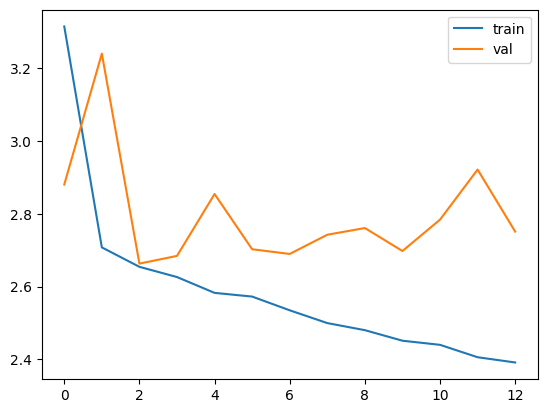

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])

### _Restoring weights from embeddings_

In [45]:
drug_names_emb_dict = {value : model.get_layer('name_of_drug_embedding').get_weights()[0][value] for key, value in label_dict['name_of_drug'].items()}
use_cases_dict = {value : model.get_layer('use_case_for_drug_embedding').get_weights()[0][value] for key, value in label_dict['use_case_for_drug'].items()}

In [46]:
model.get_layer('use_case_for_drug_embedding').get_weights()[0][0].shape

(40,)

##### Creating dataframes consisting of weights for the categorical variables

In [47]:
drug_names_df = pd.DataFrame(drug_names_emb_dict)
use_cases_df = pd.DataFrame(use_cases_dict)

###### Transposing the dataframes

In [48]:
drug_names_df = drug_names_df.T
use_cases_df = use_cases_df.T

#### _merging the dataframes_

In [49]:
data8 = data7.copy()

In [50]:
data8 = data8.merge(drug_names_df, left_on='name_of_drug', how='inner', right_on=drug_names_df.index)

In [51]:
data8 = data8.merge(use_cases_df, left_on='use_case_for_drug', right_on=use_cases_df.index, how='inner')

##### Dropping columns

In [52]:
data9 = data8.copy()

In [54]:
data9 = data9.drop(['name_of_drug', 'review_by_patient', 'use_case_for_drug'], axis=1)

### _Datetime difference_

In [55]:
data10 = data9.copy()

In [56]:
today = pd.Timestamp.today()

data10['date'] = pd.to_datetime(data10['drug_approved_by_UIC'])

data10['days'] = (today - data10['date']).dt.days

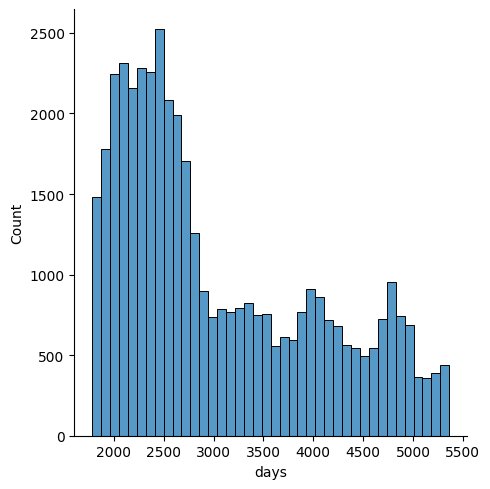

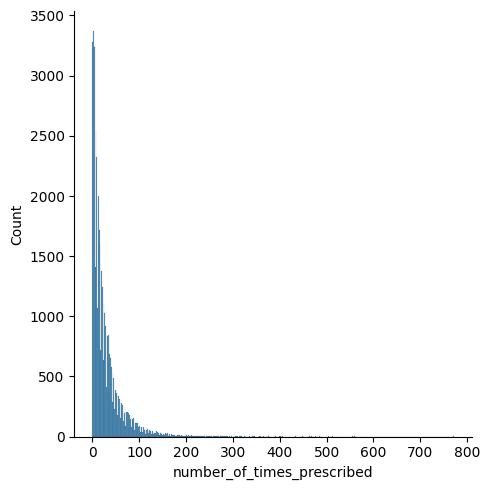

In [57]:
sns.displot(data10['days'])
sns.displot(data10['number_of_times_prescribed'])

# _Train Test Split_

In [59]:
data11 = data10.copy()

In [60]:
data11['effectivity'] = data11['number_of_times_prescribed'] * data11['effectiveness_rating'] / data11['days']

In [61]:
data12 = data11.copy()

In [85]:
Train_final = data11[data11['base_score'] != -1].reset_index(drop=True)
Test_final = data11[data11['base_score'] == -1].reset_index(drop=True)

# _Saving data as CSV_

In [91]:
Train_final.to_csv('train_final.csv', index=False)

In [94]:
Test_final.to_csv('test_final.csv', index=False)

In [63]:
X = Train_final.drop(['patient_id', 'drug_approved_by_UIC', 'base_score', 'date'], axis=1)
y = Train_final['base_score']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)